#BackProp

In [124]:
import os
from PIL import Image
import numpy as np
import pylab as pl
from scipy import misc
import re
%pylab inline

from nn.MLP import MLP as MLP1
from nn.Distances import d_log_Bernoulli_likelihood, log_Bernoulli_likelihood 

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [125]:
DATA_PATH = "../DataSets/big_alphabet_29x29/"


In [202]:
def l2dist(y, pred):
    return np.sum((pred - y)**2, axis=1).reshape(pred.shape[0], 1)

def d_l2dist(y, pred):
    return 2 * (pred - y)

def log_bernoulli(y, pred):
    iy = 1 - y
    ipred = 1 - pred
    return -np.sum(y*np.log(pred) + iy*np.log(ipred), axis=1)

def d_log_bernoulli(y, pred):
    iy = 1 - y
    ipred = 1 - pred
    return -y/pred + iy/ipred

def sigmoid(z):
    return 1 / (1 + np.exp(-z))


def d_sigmoid(z):
    s = sigmoid(z)
    return s * (1 - s)

def softmax(z):
    ex = np.exp(z)
    return ex / np.sum(ex, axis=1).reshape(ex.shape[0], 1)

def d_softmax(m):
    y = softmax(m)
    return y * (1 - y)

def idx(m):
    return m

def d_idx(m):
    return 1

In [203]:
class MLP:
    def __init__(self, input_dimension=None,
                 layers=None,
                 f_activation=None,
                 df_activation=None,
                 n_steps=200,
                 seed=179,
                 loss=l2dist,
                 d_loss=d_l2dist,
                 regularization='L2',
                 learning_rate=0.1,
                 verbose=True):
        np.random.seed(seed)
        
        if input_dimension is None:
            raise ValueError("Input dimension must not be None")

        if layers is None:
            self.n_layers = 10
            layers = [self.n_layers for _ in range(self.n_layers)]
        self.n_layers = len(layers)

        if f_activation is None or df_activation is None:
            f_activation = [sigmoid for _ in range(self.n_layers)]
            df_activation = [d_sigmoid for _ in range(self.n_layers)]

        if loss is not None and d_loss is not None:
            self.loss = loss
            self.d_loss = d_loss
        
        self.w = [None] * self.n_layers
        for i in range(0, self.n_layers):
            prev = (layers[i - 1] if i != 0 else input_dimension)
            nxt = layers[i]
            self.w[i] = np.random.normal(0, 0.1, (prev + 1, nxt))
        
        self.verbose = verbose
        self.layers = layers
        self.f_activation = f_activation
        self.df_activation = df_activation

        self.n_steps = n_steps
        self.regularization = regularization

        self.learning_rate = learning_rate

    def fit(self, X, Y, val_x, val_y, add_bias=True):
        if add_bias:
            X = np.concatenate((X, np.ones(X.shape[0]).reshape(X.shape[0], 1)), axis=1)

        err_tr = list()
        err_val = list()
        Xs = [None] * self.n_layers
        fXs = [None] * self.n_layers

        for t in range(self.n_steps):
            tmp = X
            for i in range(self.n_layers):
                Xs[i] = np.dot(tmp, self.w[i])
                tmp = self.f_activation[i](Xs[i])
                fXs[i] = tmp
                if i != self.n_layers - 1:
                    tmp = np.concatenate((tmp, np.ones(tmp.shape[0]).reshape(tmp.shape[0], 1)), axis=1)

            err_tr.append(self.loss(Y, fXs[-1]).mean())
            err_val.append(self.loss(val_y, self.predict(val_x)).mean())

            gradW = [None] * self.n_layers
            dE_n = None
            for i in reversed(range(self.n_layers)):
                dE = None
                if i == self.n_layers - 1:
                    dE = self.d_loss(Y, fXs[i]) * self.df_activation[i](Xs[i])
                    dE_n = dE
                else:
                    dE = np.dot(self.w[i + 1][:-1, :], dE_n.T).T * self.df_activation[i](Xs[i])
                    dE_n = dE
                
                inp = None
                if i == 0:
                    inp = X
                else:
                    inp = np.concatenate((fXs[i - 1], np.ones(fXs[i - 1].shape[0]).reshape(fXs[i - 1].shape[0], 1)), axis=1)

                gradW[i] = np.dot(inp.T, dE) / len(X)
                self.gradW = gradW
                
            for i in range(self.n_layers):
                #if self.regularization == 'L2':
                #    gradW[i] += 2*self.w[i]
                self.w[i] -= self.learning_rate * gradW[i]
            
            if self.verbose:
                print "Iteration {0}, cv error={1}, train error={2}".format(t, err_val[-1], err_tr[-1])

        return err_tr, err_val

    def predict(self, X, add_bias=True):
        if add_bias:
            X = np.concatenate((X, np.ones(X.shape[0]).reshape(X.shape[0], 1)), axis=1)

        tmp = np.copy(X)
        #print tmp
        for i in range(0, self.n_layers):
            tmp = np.dot(tmp, self.w[i])
            tmp = self.f_activation[i](tmp)
            #print tmp
            if i != self.n_layers - 1:
                tmp = np.concatenate((tmp, np.ones(tmp.shape[0]).reshape(tmp.shape[0], 1)), axis=1)

        return tmp

In [204]:
data = list()
target = list()
classes = list()

train_data_1 = list()
train_target_1 = list()
train_class_1 = list()

data_n = np.empty((0, 29*29))
target_n = np.empty((0, 26))
for pt in os.listdir(DATA_PATH):
    im = misc.imread(os.path.join(DATA_PATH, pt), flatten=True).flatten() / 255.0
                       
    data.append(im)
    
    parts = re.split('[-\.]', pt)
    
    c_class = int(pt[:-4].split("-")[1])
    c_target = np.zeros(26)
    c_target[c_class] = 1.0
    target.append(c_target)
    classes.append(c_class)
    
    if "mutant" not in parts or parts[2] not in ["5", "6", "7", "8"]:
        train_data_1.append(im)
        train_target_1.append(c_target)
        train_class_1.append(c_class)
    
data = np.array(data)
target = np.array(target)
classes = np.array(classes)

train_data_1 = np.array(train_data_1)
train_target_1 = np.array(train_target_1)
train_class_1 = np.array(train_class_1)



In [205]:
train_idx = np.random.randint(0, 5, size=data.shape[0])

train_data = data[train_idx != 0, ::] 
train_target = target[train_idx != 0, ::]
train_classes = classes[train_idx != 0]

val_data = data[train_idx == 0, ::] 
val_target = target[train_idx == 0, ::]
val_classes = classes[train_idx == 0]


In [206]:
print val_data.shape
print val_target.shape

(53, 841)
(53, 26)


In [207]:
mlp = MLP(input_dimension=29*29, 
          layers=[100 for i in range(1)] + [26], 
          f_activation=[sigmoid, softmax], 
          df_activation=[d_sigmoid, d_softmax],
          n_steps=2000,
          loss=log_bernoulli,
          d_loss=d_log_bernoulli,
          learning_rate=0.1)

In [208]:
errors_train, errors_val = mlp.fit(train_data, train_target, val_data, val_target)

Iteration 0, cv error=4.3741928653, train error=4.57871442361
Iteration 1, cv error=4.29778510731, train error=4.4384385648
Iteration 2, cv error=4.26763159258, train error=4.365677777
Iteration 3, cv error=4.25182949873, train error=4.31835440564
Iteration 4, cv error=4.24163850098, train error=4.28321104044
Iteration 5, cv error=4.23399052799, train error=4.25486269493
Iteration 6, cv error=4.22764257417, train error=4.23083698775
Iteration 7, cv error=4.22201519185, train error=4.20985594858
Iteration 8, cv error=4.21679372653, train error=4.19117603004
Iteration 9, cv error=4.21177960097, train error=4.17431196646
Iteration 10, cv error=4.20683330638, train error=4.15891383536
Iteration 11, cv error=4.20185348503, train error=4.14471083353
Iteration 12, cv error=4.19676988518, train error=4.1314860669
Iteration 13, cv error=4.19154030546, train error=4.11906623907
Iteration 14, cv error=4.18614676364, train error=4.10731776651
Iteration 15, cv error=4.1805886222, train error=4.0961

4.57871442361


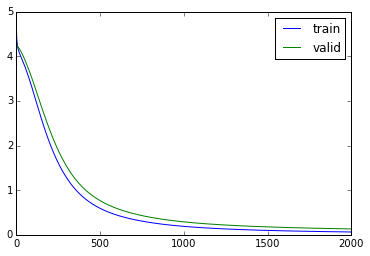

In [209]:
print errors_train[0]
pl.plot(errors_train, label="train")
pl.plot(errors_val, label="valid")
pl.legend()
pl.show()

In [210]:
val_prediction = mlp.predict(val_data)
val_ans = np.argmax(val_prediction, axis=1)

train_prediction = mlp.predict(train_data)
train_ans = np.argmax(train_prediction, axis=1)

print "Train accuracy %d/%d" % ((train_ans == train_classes).sum(), train_classes.size) 
print "Validation accuracy %d/%d" % ((val_ans == val_classes).sum(), val_ans.size) 

Train accuracy 207/207
Validation accuracy 53/53


In [156]:
eps = 1e-4
nGradW = [None]*len(mlp.w)
for t in range(len(mlp.w)):
    nGradW[t] = np.zeros(mlp.w[t].shape[0] * mlp.w[t].shape[1]).reshape(mlp.w[t].shape[0], mlp.w[t].shape[1])
    for i in range(mlp.w[t].shape[0]):
        for j in range(mlp.w[t].shape[1]):    
            res_train = mlp.predict(train_data)
            mlp.w[t][i][j] += eps
            res_train_new = mlp.predict(train_data)
            mlp.w[t][i][j] -= eps            
            ls1 = mlp.loss(res_train, train_target)
            ls2 = mlp.loss(res_train_new, train_target)
            nGradW[t][i][j] = ((ls1 - ls2) / eps).mean()

KeyboardInterrupt: 